This is a simple implementation of Generative Adversarial Networks (GAN)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        h1 = 256
        self.l1 = nn.Linear(100, h1)
        self.l2 = nn.Linear(h1, h1*2)
        self.l3 = nn.Linear(h1*2, h1*4)
        self.l4 = nn.Linear(h1*4, 28*28)
    
    def forward(self, x):
        x = x.view(-1, 100)
        x = F.leaky_relu(self.l1(x), 0.2)
        x = F.leaky_relu(self.l2(x), 0.2)
        x = F.leaky_relu(self.l3(x), 0.2)
        x = torch.tanh(self.l4(x))
        return x.view(-1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        h1 = 1024
        h2 = 128
        self.l1 = nn.Linear(28*28, h1)
        self.l2 = nn.Linear(h1, h1//2)
        self.l3 = nn.Linear(h1//2, h1//4)
        self.l4 = nn.Linear(h1//4, 1)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.l1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.l2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.l3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = self.l4(x)
        return x

In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

optimizer_dis = torch.optim.Adam(D.parameters(), lr=0.0002)
optimizer_gen = torch.optim.Adam(G.parameters(), lr=0.0002)

loss_fn = nn.BCEWithLogitsLoss()

m = 100
epoches = 100

losses_gen = []
losses_dis = []

In [5]:
for epoch in tqdm(range(epoches)):
    for n, (images, _) in enumerate(trainloader):
        images = images.to(device)
        noise = torch.randn((m, 100)).to(device)
        
        # Discriminator update
        image_fake = G(noise).detach()
        loss_fake = loss_fn(D(image_fake), torch.zeros((m, 1)).to(device))
        loss_real = loss_fn(D(images), torch.ones((m, 1)).to(device))
        loss_dis = loss_fake + loss_real
        
        D.zero_grad()
        loss_dis.backward()
        optimizer_dis.step()

        # Generator update
        gen = G(noise)
        loss_gen = loss_fn(D(gen), torch.ones((m, 1)).to(device))
        
        G.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()
        
        # Logging
        losses_dis.append(loss_dis.detach().cpu())
        losses_gen.append(loss_gen.detach().cpu())

100%|██████████| 100/100 [06:45<00:00,  4.05s/it]


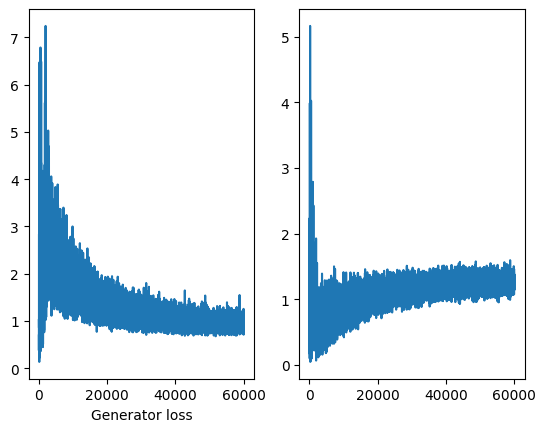

In [8]:
plt.subplot(1, 2, 1)
plt.plot(losses_gen); plt.xlabel('Generator loss')
plt.subplot(1, 2, 2)
plt.plot(losses_dis)
plt.show()

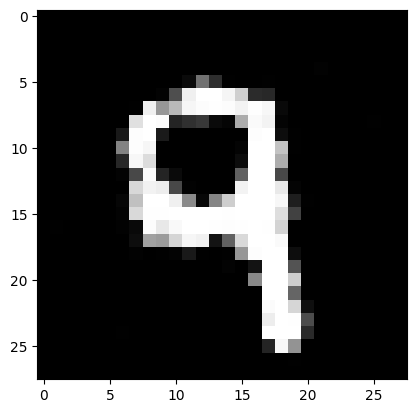

In [12]:
# Visualize a generated image
import random

n = random.choice(range(gen.shape[0]))
plt.imshow(gen[n].squeeze().detach().cpu(), cmap='gray')
plt.show()